# Week 8

This week, we consider Inception nets (Szegedy, et al., 2014 https://arxiv.org/abs/1409.4842), which are CNNs with so-called inception modules, which are small groupings of parallel convolutional layers that act on the same input feature map, processes it through different means, and concatenates the results. In particular, it uses convolutional layers with different-sized filters (1x1, 3x3, and 5x5 in Inception-v1), which are adept at finding patterns at different scales.

In this notebook, we implement a small version of Inception and test it on the CIFAR-10 dataset.

## GPU Computing

CNNs especially benefit from parallelization within GPUs. Only NVIDIA video cards are currently compatible, which can be in your local device or in a cloud. The following code can check if tensorflow sees a GPU

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


## MiniGoogLeNet

Note for GoogLeNet, the inception modules are not exactly sequential, so we will need to define layers a little differently as we see below, after importing some packages. And, we use "miniception" modules as per *Understanding Deep Learning Requires Re-Thinking Generalization* (Zhang, et al., 2017 http://arxiv.org/abs/1611.03530), which work well for small-dimensional image datasets.

In [5]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
class MiniGoogLeNet:
    def convolution_module(x, K, kX, kY, stride, channelsDim, padding="same"):
        # create a CONV -> BN -> RELU sequence
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = BatchNormalization(axis = channelsDim)(x)
        x = Activation('relu')(x)
        
        # return the output
        return x
    
    def inception_module(x, numberOf1x1Kernels, numberOf3x3Kernels, channelsDim):
        # define two "parallel" convolutions of size 1x1 and 3x3 concatenated across the channels dimension
        convolution_1x1 = MiniGoogLeNet.convolution_module(x, numberOf1x1Kernels, 1, 1, (1, 1), channelsDim)
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, numberOf3x3Kernels, 3, 3, (1, 1), channelsDim)
        x = concatenate([convolution_1x1, convolution_3x3], axis = channelsDim)
        
        return x
        
    def downsample_module(x, K, channelsDim):
        # define a CONV and POOL and then concatenate across the channels dimension
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, K, 3, 3, (2, 2), channelsDim, padding = 'valid')
        pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
        x = concatenate([convolution_3x3, pool], axis = channelsDim)
        
        return x
    
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            channelsDim = 1
        
        # define the model input and first CONV module
        inputs = Input(shape = inputShape)
        x = MiniGoogLeNet.convolution_module(inputs, 96, 3, 3, (1, 1), channelsDim)
        
        # two inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 80, channelsDim)
        
        # four inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 96, channelsDim)
        
        # two inception modules followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation('softmax')(x)
        
        # create a model
        model = Model(inputs, x, name='MiniGoogLeNet')
        
        # return the model
        return model

### MiniGoogLeNet on CIFAR-10

Let's test it on CIFAR-10

In [7]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

[INFO] compiling model...
[INFO] training network...
Epoch 1/70
782/782 [==============================] - 18s 22ms/step - loss: 1.4005 - accuracy: 0.4914 - val_loss: 1.0960 - val_accuracy: 0.6037
Epoch 2/70
782/782 [==============================] - 16s 20ms/step - loss: 0.9681 - accuracy: 0.6576 - val_loss: 0.9037 - val_accuracy: 0.6841
Epoch 3/70
782/782 [==============================] - 16s 20ms/step - loss: 0.7853 - accuracy: 0.7258 - val_loss: 0.9517 - val_accuracy: 0.6739
Epoch 4/70
782/782 [==============================] - 16s 20ms/step - loss: 0.6575 - accuracy: 0.7711 - val_loss: 0.7985 - val_accuracy: 0.7282
Epoch 5/70
782/782 [==============================] - 16s 20ms/step - loss: 0.5596 - accuracy: 0.8065 - val_loss: 0.9606 - val_accuracy: 0.6872
Epoch 6/70
782/782 [==============================] - 16s 20ms/step - loss: 0.4847 - accuracy: 0.8332 - val_loss: 0.9856 - val_accuracy: 0.6922
Epoch 7/70
782/782 [==============================] - 16s 20ms/step - loss: 0.4243 

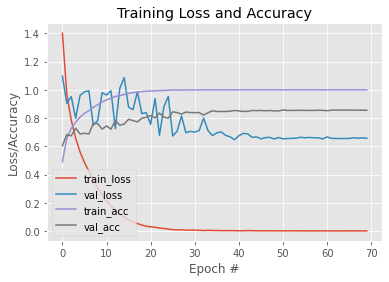

In [11]:
numberOfEpochs = 70
initialLearningRate = 0.005

def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha
    
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype('float')
testX = testX.astype('float')

# use mean subtraction
mean = np.mean(trainX, axis = 0)
trainX -= mean
testX -= mean

# convert labels to one-hot
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

callbacks = [LearningRateScheduler(polynomial_decay)]

print('[INFO] compiling model...')
opt = SGD(learning_rate = initialLearningRate, momentum=0.9)
model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

# print a model summary
#print(model.summary())

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data = (testX, testY), batch_size = 64, epochs = numberOfEpochs,
              callbacks = callbacks, verbose = 1)

# save the network to disk
#print("[INFO] serializing network...")
#model.save('output/MiniGoogLeNet_cifar10.hdf5')

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This results in 85% accuracy, which is pretty good, but it seems to be overfitting.

### GoogLeNet Experiment 2: Data Augmentation

Let's see if data augmentation helps with the overfitting problem.

In [ ]:
numberOfEpochs = 70
initialLearningRate = 0.005

def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha
    
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype('float')
testX = testX.astype('float')

# use mean subtraction
mean = np.mean(trainX, axis = 0)
trainX -= mean
testX -= mean

# convert labels to one-hot
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,
                         horizontal_flip = True, fill_mode="nearest")

callbacks = [LearningRateScheduler(polynomial_decay)]

print('[INFO] compiling model...')
opt = SGD(learning_rate = initialLearningRate, momentum=0.9)
model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")

H = model.fit(aug.flow(trainX, trainY, batch_size=64), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 64, epochs=numberOfEpochs, callbacks = callbacks, verbose=1)

# print a model summary
# print(model.summary())

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

[INFO] compiling model...
[INFO] training network...
Epoch 1/70
781/781 [==============================] - 18s 22ms/step - loss: 1.4982 - accuracy: 0.4532 - val_loss: 1.4011 - val_accuracy: 0.5273
Epoch 2/70
781/781 [==============================] - 17s 21ms/step - loss: 1.0780 - accuracy: 0.6126 - val_loss: 1.3076 - val_accuracy: 0.5547
Epoch 3/70
781/781 [==============================] - 17s 21ms/step - loss: 0.9063 - accuracy: 0.6819 - val_loss: 1.4028 - val_accuracy: 0.5718
Epoch 4/70
781/781 [==============================] - 16s 21ms/step - loss: 0.7892 - accuracy: 0.7267 - val_loss: 0.8165 - val_accuracy: 0.7219
Epoch 5/70
781/781 [==============================] - 17s 21ms/step - loss: 0.7073 - accuracy: 0.7558 - val_loss: 1.0414 - val_accuracy: 0.6750
Epoch 6/70
781/781 [==============================] - 17s 21ms/step - loss: 0.6422 - accuracy: 0.7788 - val_loss: 0.8100 - val_accuracy: 0.7342
Epoch 7/70
781/781 [==============================] - 17s 21ms/step - loss: 0.5952 

We've now cracked 90% for the first time with CIFAR-10!